Prepare the dataset

In [1]:
!pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=13d473c1687fc8faf877fee0a93d3cdea825fddb7db46637d2f535b1b45ccf67
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [2]:
import wget
import zipfile

data_url = "https://download.pytorch.org/tutorial/data.zip"
filename = wget.download(data_url)

with zipfile.ZipFile(filename) as zf:
    zf.extractall()

In [3]:
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['data/names/Irish.txt', 'data/names/Polish.txt', 'data/names/Japanese.txt', 'data/names/English.txt', 'data/names/Arabic.txt', 'data/names/Scottish.txt', 'data/names/French.txt', 'data/names/German.txt', 'data/names/Russian.txt', 'data/names/Dutch.txt', 'data/names/Italian.txt', 'data/names/Portuguese.txt', 'data/names/Korean.txt', 'data/names/Vietnamese.txt', 'data/names/Chinese.txt', 'data/names/Greek.txt', 'data/names/Czech.txt', 'data/names/Spanish.txt']
Slusarski


In [4]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


In [5]:
print(category_lines['Arabic'][:5])

['Khoury', 'Nahas', 'Daher', 'Gerges', 'Nazari']


Turning Names into Tensors

In [6]:
import torch


# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


Creating the Neural Network

In [7]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.h2o(hidden)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [8]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

In [9]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.7643, -2.8939, -2.9530, -2.9767, -2.8915, -2.8890, -2.8699, -2.8923,
         -2.8359, -2.8856, -2.8618, -2.9462, -2.9282, -2.9305, -2.9451, -2.8444,
         -2.8888, -2.8520]], grad_fn=<LogSoftmaxBackward0>)


In [10]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Irish', 0)


In [11]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Spanish / line = Esparza
category = Vietnamese / line = Phi
category = Russian / line = Dovbyschuk
category = Scottish / line = Shaw
category = Greek / line = Close
category = Italian / line = Spini
category = Arabic / line = Essa
category = Vietnamese / line = Quach
category = Irish / line = Taidhg
category = Czech / line = Subertova


Training the Network

In [12]:
criterion = nn.NLLLoss()

In [13]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [18]:
import time
import math
from tqdm.auto import tqdm

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in tqdm(range(1, n_iters + 1)):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print ``iter`` number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

  0%|          | 0/100000 [00:00<?, ?it/s]

5000 5% (0m 7s) 6.0154 Budny / Scottish ✗ (Polish)
10000 10% (0m 15s) 1.1125 O'Hannagain / Irish ✓
15000 15% (0m 23s) 0.6530 Romano / Italian ✓
20000 20% (0m 30s) 5.8600 Roosa / Spanish ✗ (Dutch)
25000 25% (0m 41s) 0.3116 Farrell / Irish ✓
30000 30% (0m 48s) 0.4708 Ceallach / Irish ✓
35000 35% (0m 56s) 0.5789 O'Hara / Irish ✓
40000 40% (1m 5s) 1.6644 Leeuwenhoeck / Polish ✗ (Dutch)
45000 45% (1m 13s) 0.0112 Rovnev / Russian ✓
50000 50% (1m 21s) 1.4145 Suaird / Arabic ✗ (Irish)
55000 55% (1m 29s) 0.3394 Chou / Korean ✓
60000 60% (1m 37s) 0.7981 Savona / Italian ✓
65000 65% (1m 45s) 0.6333 Chu / Vietnamese ✓
70000 70% (1m 52s) 0.7799 Porra / Spanish ✓
75000 75% (2m 0s) 2.1853 Piller / English ✗ (Czech)
80000 80% (2m 8s) 0.0817 Reijnders / Dutch ✓
85000 85% (2m 15s) 1.2580 Yang / Chinese ✗ (Korean)
90000 90% (2m 24s) 0.1803 Harb / Arabic ✓
95000 95% (2m 31s) 0.7759 Watt / Scottish ✓
100000 100% (2m 39s) 2.5868 Granger / French ✗ (English)


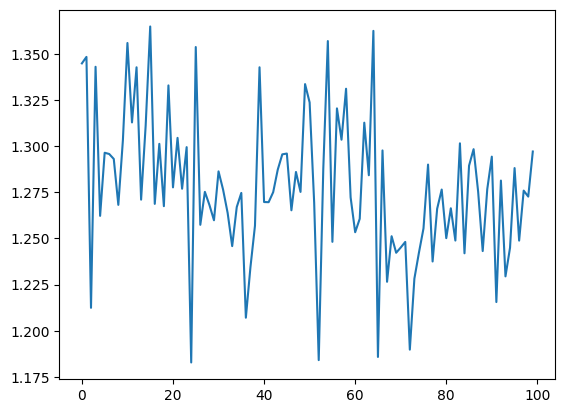

In [19]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

<ipython-input-20-a5b341ffc3a3>:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
<ipython-input-20-a5b341ffc3a3>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


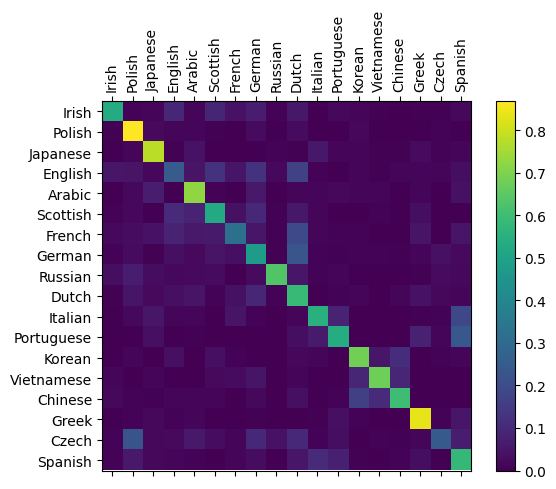

In [20]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [30]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

        return input_line, predictions

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.56) Czech
(-1.23) Russian
(-2.76) English

> Jackson
(-0.37) Scottish
(-2.15) Arabic
(-2.46) English

> Satoshi
(-0.41) Arabic
(-1.64) Japanese
(-2.84) Italian


('Satoshi',
 [[-0.4051307737827301, 'Arabic'],
  [-1.6353117227554321, 'Japanese'],
  [-2.838651180267334, 'Italian']])

In [31]:
answer = predict('Sarah')


> Sarah
(-0.61) Arabic
(-1.68) Irish
(-2.41) Polish


In [33]:
answer

('Sarah',
 [[-0.6105876564979553, 'Arabic'],
  [-1.6777658462524414, 'Irish'],
  [-2.4096126556396484, 'Polish']])

In [35]:
torch.save(rnn.state_dict(), "name_classifier_rnn.pth")

In [36]:
%%bash
git config --global user.name 'deniandriancode'
git config --global user.email 'deniandriancode@gmail.com'

In [37]:
!git clone https://github.com/deniandriancode/colab-notebooks.git

Cloning into 'colab-notebooks'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 9 (delta 2), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (9/9), 99.95 KiB | 3.33 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [38]:
%cd colab-notebooks

/content/colab-notebooks


In [40]:
!cp ../name_classifier_rnn.pth .
!git add .
!git commit -m 'add model'
!git push https://deniandriancode:<TOKEN>@github.com/deniandriancode/colab-notebooks.git

On branch main
Your branch is ahead of 'origin/main' by 1 commit.
  (use "git push" to publish your local commits)

nothing to commit, working tree clean
Enumerating objects: 4, done.
Counting objects: 100% (4/4), done.
Delta compression using up to 2 threads
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 96.19 KiB | 13.74 MiB/s, done.
Total 3 (delta 0), reused 0 (delta 0), pack-reused 0
To https://github.com/deniandriancode/colab-notebooks.git
   526a816..f9f990f  main -> main
